In [2]:
import pandas as pd
import numpy as np
import io

from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data = pd.read_csv(r'/content/gdrive/My Drive/TSSData/TSSData1.csv')

csvs = ['/content/gdrive/My Drive/TSSData/TSSData' + str(i) + '.csv' for i in range(2, 29)]

In [4]:
# Combine the various csvs obtained from https://smarterroads.org/dataset/detail/1

for c in csvs:
  d = pd.read_csv(c)
  data = pd.concat([data, d])

In [5]:
data.shape

(21064361, 20)

In [6]:
# Drop fields with no predictive power

keep_cols = ['timeStamp', 'ns2:lanenum', 'ns2:occupancy', 'ns2:speed', 'ns2:volume', 'ns2:sample_period', 'ns3:pos', 'ns2:lane_direction', 'ns2:lanetype', 'ns2:mile_marker', 'ns2:routename']
traff = data.loc[:, keep_cols]

In [7]:
# Extract each aspect of time as a new column

traff['month'] = pd.to_datetime(traff['timeStamp']).apply(lambda x: x.month)
traff['day'] = pd.to_datetime(traff['timeStamp']).apply(lambda x: x.day)
traff['hour'] = pd.to_datetime(traff['timeStamp']).apply(lambda x: x.hour)
traff['min'] = pd.to_datetime(traff['timeStamp']).apply(lambda x: x.minute)

In [8]:
traff.drop('timeStamp', axis=1, inplace=True)
traff.head()

,ns2:lanenum,ns2:occupancy,ns2:speed,ns2:volume,ns2:sample_period,ns3:pos,ns2:lane_direction,ns2:lanetype,ns2:mile_marker,ns2:routename,month,day,hour,min
0,1.0,2.0,68.0,22.0,300.0,37.6725 -77.49389,S,NORMAL,6.8,I-295S,1,1,5,59
1,3.0,0.0,65.0,0.0,60.0,0.036868 -7.642243,E,Main,0.0,164,1,1,5,59
2,4.0,2.0,81.0,5.0,60.0,0.036868 -7.642243,E,Main,0.0,164,1,1,5,59
3,1.0,3.0,63.0,7.0,60.0,36.79414 -76.38933,W,Main,0.0,I-264,1,1,5,59
4,2.0,4.0,58.0,10.0,60.0,36.79414 -76.38933,W,Main,0.0,I-264,1,1,5,59


In [9]:
traff.shape

(21064361, 14)

In [11]:
traff.to_csv('trafficdata_full')

In [ ]:
traff = pd.read_csv('trafficdata_full')

In [13]:
# Initially focus on a single route of traffic and expand later

traff = traff[(traff['ns2:routename'] == '164') & (traff['ns2:lanenum'] == 1)]
traff.shape

(39380, 14)

In [14]:
# Create latitude and logitude columns

traff[['lat','long']] = traff['ns3:pos'].str.split(expand=True)

In [20]:
traffic = traff.drop(['ns3:pos', 'ns2:lane_direction', 'ns2:lanetype', 'ns2:routename', 'ns2:lanenum'], axis=1)

In [21]:
# Sort columns by time to ensure the correct ordering (add year when looking further back)

traffic = traffic.sort_values(['month', 'day', 'hour', 'min'], ascending=[True, True, True, True])
traffic.head()

,ns2:occupancy,ns2:speed,ns2:volume,ns2:sample_period,ns2:mile_marker,month,day,hour,min,lat,long
13,1.0,58.0,3.0,60.0,0.0,1,1,5,59,0.368595,-7.634928
16,1.0,46.0,1.0,60.0,0.0,1,1,5,59,3.687296,-7.637849
25,3.0,60.0,6.0,60.0,0.0,1,1,5,59,3.686817,-7.636024
486,7.0,61.0,17.0,60.0,0.0,1,1,5,59,3.687241,-7.639407
490,3.0,58.0,5.0,60.0,0.0,1,1,5,59,0.036868,-7.642243


In [24]:
# Scale all of the variables

scaler = MinMaxScaler(feature_range=(0, 1))

traffic = scaler.fit_transform(traffic)
pd.DataFrame(traffic).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.016667,0.595745,0.075,0.0,0.0,0.0,0.0,0.217391,1.0,0.090873,1.000000
1,0.016667,0.468085,0.025,0.0,0.0,0.0,0.0,0.217391,1.0,1.000000,0.600684
2,0.050000,0.617021,0.150,0.0,0.0,0.0,0.0,0.217391,1.0,0.999869,0.850171
3,0.116667,0.627660,0.425,0.0,0.0,0.0,0.0,0.217391,1.0,0.999985,0.387697
4,0.050000,0.595745,0.125,0.0,0.0,0.0,0.0,0.217391,1.0,0.000000,0.000000


In [30]:
def convert2ML(df, lookback = 20, train_perc = 0.7):
  """ Convert the current data into a form that can be used by an LTSM. First by creating training and test sets, then by converting to time slices, and finally be reshaping """

  global look_back
  look_back = lookback
  # Create training and test sets
  train_size = int(round(len(df) * train_perc, 0))
  train = traffic[0:train_size, :]
  test = traffic[train_size:-1, :]
  train_y = train[(look_back+1):-1, 0]
  test_y = test[(look_back+1):-1, 0]

  
  def structure(data, lookback):
    """ Organize data to be a series of time slices equal to the lookback length """

    x = []
    for i in range(lookback, data.shape[0]):
      x.append(data[(i-lookback):i, :])

    return np.array(x)

  train = structure(train, look_back)
  test = structure(test, look_back)

  train_X = train[:-2, :, :]
  test_X = test[:-2, :, :]
  train_y = train_y.reshape(-1, 1, 1)
  test_y = test_y.reshape(-1, 1, 1)

  return train_X, test_X, train_y, test_y

In [36]:
train_X, test_X, train_y, test_y = convert2ML(traffic, 90, 0.7)

In [37]:
train_y.shape

(27474, 1, 1)

In [38]:
train_X.shape

(27474, 90, 11)

In [39]:
model = keras.Sequential()

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128, input_shape=(look_back, 11)))

# Add a Dense layer with 1 units.
model.add(layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               71680     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 71,809
Trainable params: 71,809
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(train_X, train_y, epochs=30,
                    validation_data=(test_X, test_y))

Epoch 1/30
859/859 [==============================] - 7s 7ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 2/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0012 - val_loss: 7.2923e-04
Epoch 3/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0011 - val_loss: 7.2972e-04
Epoch 4/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0011 - val_loss: 8.7842e-04
Epoch 5/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0011 - val_loss: 7.6000e-04
Epoch 6/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0010 - val_loss: 7.5896e-04
Epoch 7/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0011 - val_loss: 7.0312e-04
Epoch 8/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0012 - val_loss: 6.8066e-04
Epoch 9/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0010 - val_loss: 8.7747e-04
Epoch 10/30
859/859 [==============================] - 6s 7ms/step -

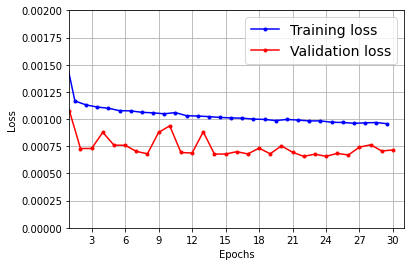

In [48]:
# Plot the training progress

def plot_learning_curves(loss, val_loss, epochs = 30):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, epochs + 1, 0, 0.002])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [43]:
y1 = np.squeeze(model.predict(test_X))[0:100]
y2 = np.squeeze(test_y)[0:100]

In [44]:
x = np.arange(len(test_y))[0:100]

Text(0.5, 1.0, 'Occupancy Predictions')

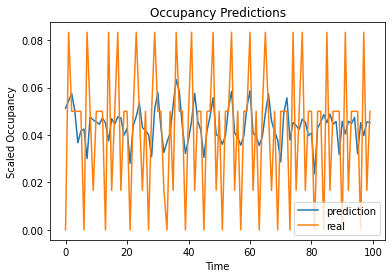

In [45]:
# Plot the model predictions versus realized occupancy rates for the first 100 observations

plt.plot(x, y1, label='prediction')
plt.plot(x, y2, label='real')
plt.legend(loc="lower right")
plt.xlabel('Time')
plt.ylabel('Scaled Occupancy')
plt.title('Occupancy Predictions')

In [ ]:
import os
import tensorflow as tf

model_version = "0001"
model_name = "traffic_data_model"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: traffic_data_model/0001/assets


In [ ]:
!zip -r /content/model.zip /content/traffic_data_model/

  adding: content/traffic_data_model/ (stored 0%)
  adding: content/traffic_data_model/0001/ (stored 0%)
  adding: content/traffic_data_model/0001/variables/ (stored 0%)
  adding: content/traffic_data_model/0001/variables/variables.index (deflated 58%)
  adding: content/traffic_data_model/0001/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/traffic_data_model/0001/assets/ (stored 0%)
  adding: content/traffic_data_model/0001/saved_model.pb (deflated 90%)
